# Devices with Gaussian Disorder: contact barrier and image-force barrier lowering

This example reproduces steady-state drift-diffusion simulations of unipolar organic diodes from the  [reference](https://doi.org/10.1103/PhysRevB.79.085203).

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import io
import numpy as np
from oedes import *
init_notebook()

## Model and parameters

Univariate interpolation of Gauss-Fermi integral is used to speed up the calculation. This is possible, because $\sigma/{k T}$ is not allowed to vary continuously in this example.

In [2]:
def egdmholeonly(L, image_force=True, z=1):
    m = models.BaseModel()
    mesh = fvm.mesh1d(L)
    poisson = Poisson(mesh)
    poisson.bc = [models.AppliedVoltage(boundary) for boundary in mesh.boundaries]
    thermal=models.ConstTemperature()    
    impl = functions.gdos.UnivariateInterpolatedGaussFermiFactory(
        functions.gdos.defaultImpl)
    dos = models.egdm.GaussianDOS(impl=impl)
    charge = models.BandTransport(poisson=poisson,name='charge',z=z,dos=dos,mobility_model=models.egdm.EGDMMobility(),thermal=thermal)
    charge.bc = [models.FermiLevelEqualElectrode(
        b, image_force=image_force) for b in mesh.boundaries]
    m=models.CompositeModel([poisson,thermal,charge,models.RamoShockleyCurrentCalculation([poisson])])
    m.setUp()
    return m

In [3]:
egdmholeonly(100e-9)

In [4]:
default_params = {
    'T': 298.,
    'epsilon_r': 3.,
    'charge.N0': 1.6e-9**-3.,
    'charge.energy': 0.,
    'electrode0.workfunction': 0,
    'electrode1.workfunction': 0,
    'electrode0.voltage': 0,
    'electrode1.voltage': 0.
}

Simulation and plotting functions for this example:

In [5]:
def figiv(sigmaeV, mu0, maxv, L, n=41, sign=1, z=1):
    params = default_params.copy()
    nsigma = sigmaeV / functions.ThermalVoltage(params['T'])
    models.egdm.egdm_params_simple(params,'charge', nsigma, 1.6e-9, mu0)
    m = egdmholeonly(L, image_force=True, z=z)
    bar_sweep = sweep('charge.energy', -np.linspace(0., 1., 4))
    v_sweep = sweep('electrode0.voltage',sign*np.logspace(np.log10(maxv) -2,np.log10(maxv),n))
    c=context(m)
    for bar,cbar in c.sweep(params, bar_sweep):
        for _ in cbar.sweep(cbar.params, v_sweep):
            pass
        v, j = cbar.teval(v_sweep.parameter_name, 'J')
        testing.store(j, rtol=1e-4)
        plt.plot(v, sign * j, label='$\Delta$ = %.2f eV' % bar)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('V')
    plt.ylabel(r'$\mathrm{A/m^2}$')
    plt.title(r'L=%s nm, $\sigma$=%s eV' % (L * 1e9, sigmaeV))
    plt.legend(loc=0)
    plt.show()

In [6]:
def figib(sigmaeV=None, mu0=None, L=22e-9, n=76, sign=1, z=1):
    params = default_params.copy()
    nsigma = sigmaeV / functions.ThermalVoltage(params['T'])
    models.egdm.egdm_params_simple(params,'charge', nsigma, 1.6e-9, mu0)
    params['electrode0.voltage'] = sign * 2.
    for image,label in progressbar([(True, 'with image force correction'), (False, 'without image force correction')],'image'):
        m = egdmholeonly(L, image_force=image, z=z)
        c = context(m)
        for _ in c.sweep(params,sweep('charge.energy', -np.linspace(0., 1.5, n))):
            pass
        bar, j = c.teval('charge.energy', 'J')
        testing.store(j, rtol=1e-4)
        plt.plot(bar, sign * j, label=label)
    plt.yscale('log')
    plt.xlabel(r'$\mathrm{\Delta}$')
    plt.ylabel(r'$\mathrm{A/m^2}$')
    plt.title(r'L=%s nm, $\sigma$=%s eV' % (L * 1e9, sigmaeV))
    plt.legend(loc=0)
    plt.show()

## Results

### Current-voltage characteristics for devices with different thickness $L$, Gaussian disorder $\sigma$ and contact barrier $\Delta$.

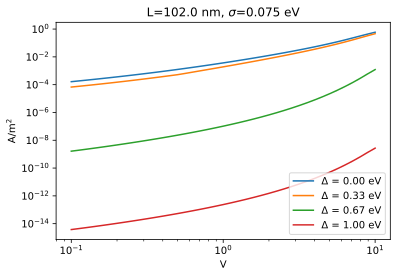

In [7]:
figiv(sigmaeV=0.075, mu0=4.8e-14, maxv=10., L=102e-9)

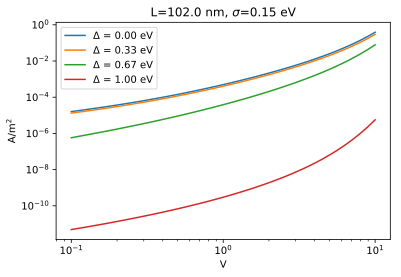

In [8]:
figiv(sigmaeV=0.150, mu0=1.6e-16, maxv=10., L=102e-9)

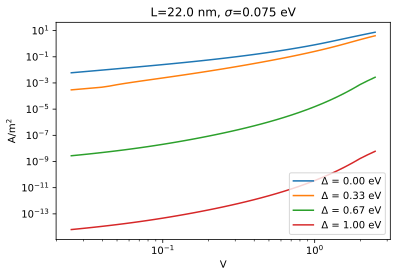

In [9]:
figiv(sigmaeV=0.075, mu0=4.8e-14, maxv=2.5, L=22e-9)

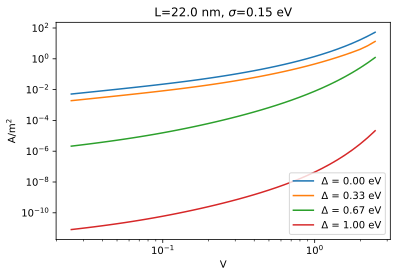

In [10]:
figiv(sigmaeV=0.150, mu0=1.6e-16, maxv=2.5, L=22e-9)

### Current density through device with fixed length $L$ and disorder $\sigma$, and varying contact barrier $\Delta$. 

Like in the reference, the effect of image force correction is considered. It leads to a reduction of effective contact barrier by approximately 0.3 eV.

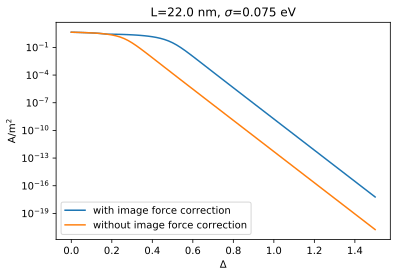

In [11]:
figib(sigmaeV=0.075, mu0=4.8e-14, L=22e-9)

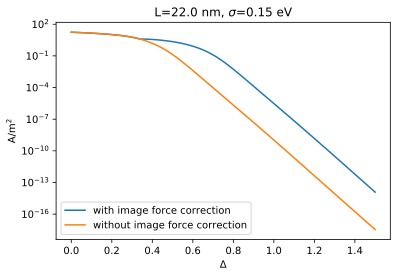

In [12]:
figib(sigmaeV=0.150, mu0=1.6e-16, L=22e-9)

## Reference

J. J. M. van der Holst, M. A. Uijttewaal, B. Ramachandhran, R. Coehoorn, P. A. Bobbert, [Modeling and analysis of the three-dimensional current density in sandwich-type single-carrier devices of disordered organic semiconductors](https://doi.org/10.1103/PhysRevB.79.085203), Phys. Rev. B 79, 085203 (2009).


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
